In [1]:
import pandas as pd
import numpy as np
import praw
import matplotlib.pyplot as plt
from psaw import PushshiftAPI
import time
import seaborn as sns


# 1. Getting Data from reddit Using praw API wrapper

In [3]:
reddit = praw.Reddit(client_id = '',     # this is that personal use script key
                     client_secret = '', # this is that secret key
                     user_agent = '',    # Whatever name you gave your application
                     username = '',      # your Reddit user name
                     password = '')      # your Reddit password

In [4]:
api = PushshiftAPI(reddit)

In [5]:
def get_dataframe(X):
    df = {'title':[],
          'body':[],
          'created':[]}

    counter = 0 # initializing counting variable
    sleep_counter = 0 # initializing sleep_counter variable
    for item in api.search_submissions(subreddit=X, limit=5_000):
        if item.created>new:  #comment out when run this program first time, since we need go get all the data
            df["title"].append(item.title)
            df["created"].append(item.created)
            df["body"].append(item.selftext)
            counter +=1
            sleep_counter += 1
            if sleep_counter > 999:
                print(counter)
                time.sleep(3)
                sleep_counter = 0 
    return pd.DataFrame(df)

In [6]:
# Only run in the first time
# wow = get_dataframe('wow')
# wow_c = get_dataframe('classicwow')
# wow.to_csv('./dataset/20191019_wow.csv')
# wow_c.to_csv('./dataset/20191019_wow_c.csv')


In [7]:
def cleaning(dfx):
    dfx.replace('[已移除]', '', inplace = True)
    dfx.replace('[刪除]', '', inplace = True)
    return dfx

# 2. Cleaning Text data

In [8]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

In [9]:
tokenizer = RegexpTokenizer('(?u)\\b\\w\\w+\\b')

In [10]:
def magic(df1, df2):
    df1 = cleaning(df1)
    df2 = cleaning(df2)
    df1['X'] = df1['title'] + df1['body']
    df1['y'] = 1
    df2['X'] = df2['title'] + df2['body']
    df2['y'] = 0
    df1['Xs'] = [' '.join([PorterStemmer().stem(i) for i in tokenizer.tokenize(j)]) for j in df1['X']]
    df2['Xs'] = [' '.join([PorterStemmer().stem(i) for i in tokenizer.tokenize(j)]) for j in df2['X']] 
    return pd.concat([df1,df2], axis = 0, ignore_index= True)

In [11]:
# run for the first time. save combined data into df_combine.csv
# df = magic(wow,wow_c)
# df.to_csv('./dataset/df_combine.csv')

In [12]:
# After saving the data and 
wow = pd.read_csv('./dataset/20191019_wow.csv')
wow_c =  pd.read_csv('./dataset/20191019_wow_c.csv')
df = pd.read_csv('./dataset/df_combine.csv')
# y variable 0 means wow_classic, 1 means wow

In [13]:
new = wow['created'].sort_values(ascending = False)[0]

import datetime as dt
date = dt.datetime.fromtimestamp(new)
pd.to_datetime(date)

Timestamp('2019-10-15 21:16:53')

# 3. Start to making Model

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

In [109]:
# Found the top 50 common words for both subreddit and add them together with stop words
dwords = pd.read_csv('./dataset/duplicatewords.csv')

In [110]:
dwords.drop('Unnamed: 0', axis = 1, inplace = True)

In [111]:
dwords = [i for i in dwords['0']]

In [112]:
stop = stopwords.words('english') + dwords

In [113]:
df = df[df['Xs'].notnull()]

In [114]:
X = df['Xs'] # using stemed data to make model
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [93]:
# initialize CountVectorizer and TfidVectorizer
cvect = CountVectorizer(max_features= 3000, stop_words= stop, ngram_range=(1,2))
tvect = TfidfVectorizer(max_features= 3000, stop_words= stop, ngram_range=(1,2))

In [94]:
# Transform for cvect and tvect and for training and testing
Xcvect_tr = pd.DataFrame(cvect.fit_transform(X_train).toarray() ,columns = cvect.get_feature_names())
Xcvect_te = pd.DataFrame(cvect.transform(X_test).toarray() ,columns = cvect.get_feature_names())

Xtvect_tr = pd.DataFrame(tvect.fit_transform(X_train).toarray() ,columns = tvect.get_feature_names())
Xtvect_te = pd.DataFrame(tvect.transform(X_test).toarray() ,columns = tvect.get_feature_names())

In [95]:
# Run first time to get duplicate words
# xt = Xtvect_tr.T
# xt['sum']=[Xtvect_tr.T.iloc[i,:].sum() for i in range(len(Xtvect_tr.T))]
# dwords = xt.sort_values('sum', ascending = False).head(50).index
# pd.DataFrame(list(dwords)).to_csv('./dataset/duplicatewords.csv')

## 3.1 Setting Parameter

In [96]:
pipe_log = {
            'C':[1e-9,1,1e9]
            }

pipe_knn = {
            'n_neighbors':[3,7,10,15]
           }

pipe_dt = {'max_depth':[5,7,9],
          'min_samples_split':[7,11,15],
          'min_samples_leaf':[3,4,5,6]
          }
pipe_mu = {}

pipe_svc = {
            'C':[1e-5,1,1e5],
            'kernel':['rbf']
}

pipe_rf = {
        'n_estimators':[5,10,20],
        'max_depth':[3,4],
        'min_samples_leaf':[4,5,6]
}

## 3.2 Setting GridSearch model
##### Using, LogisticRegression, Knn, DecisionTree, Multinomial, SVC

In [97]:
g_log = GridSearchCV(LogisticRegression(), pipe_log, cv = 5)
g_knn = GridSearchCV(KNeighborsClassifier(), pipe_knn, cv = 5)
g_dt = GridSearchCV(DecisionTreeClassifier(), pipe_dt, cv = 5) 
g_mu = GridSearchCV(MultinomialNB(), pipe_mu, cv = 5)
g_svc = GridSearchCV(SVC(), pipe_svc , cv = 5)
g_rf = GridSearchCV(RandomForestClassifier(), pipe_rf, cv = 5)

In [98]:
import time
import warnings
warnings.filterwarnings("ignore") #ignore warning

In [99]:
# Using this function to get score for training, testing and operate time
def get_score(Xtrain,Xtest,y,g_model):
    t0 = time.time()
    g_model.fit(Xtrain,y)
    model = g_model.best_estimator_
    param = g_model.best_params_
    t1 = time.time() - t0
    return [model.score(Xtrain, y_train), model.score(Xtest, y_test), param, t1] 

In [100]:
models = [g_log, 
#           g_knn, comment out because it will take long time to run
#           g_dt, comment out because it will take long time to run
          g_mu, 
          g_rf,
#           g_svc, comment out because it will take long time to run
         ]
di = {g_log:'Logistic',
     g_knn:'Knn',
     g_dt:'Decision Tree',
     g_mu:'Multinomial',
     g_rf:'Random Forest',
     g_svc:'SVC'
     }

In [101]:
list_of_result = []

In [102]:
# getting a dataframe of result
# WARNING: run this cell is going to take long time
for i in models:
    list_of_result.append( [di[i]] + ['Cvect'] + get_score(Xcvect_tr, Xcvect_te, y_train, i))
    list_of_result.append( [di[i]] + ['Tvect'] + get_score(Xtvect_tr, Xtvect_te, y_train, i))
result = pd.DataFrame(list_of_result, columns = [ 'Model', 'V method','Train Score','Test Score', 'Best Param','Time to run'])

In [103]:
result

,Model,V method,Train Score,Test Score,Best Param,Time to run
0,Logistic,Cvect,0.871247,0.740696,{'C': 1},5.741941
1,Logistic,Tvect,0.846031,0.751501,{'C': 1},14.743778
2,Multinomial,Cvect,0.788125,0.745098,{},1.127007
3,Multinomial,Tvect,0.824016,0.749100,{},0.659860
4,Random Forest,Cvect,0.656971,0.649060,"{'max_depth': 4, 'min_samples_leaf': 6, 'n_est...",24.801034
5,Random Forest,Tvect,0.645497,0.626251,"{'max_depth': 4, 'min_samples_leaf': 6, 'n_est...",24.954626


In [104]:
# based on the table above, we can see the model with the best test score is logistic model that has C=1 with Tvect
model = LogisticRegression(C = 1)

In [105]:
model.fit(Xtvect_tr, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [106]:
coef1 = pd.DataFrame(zip(Xtvect_tr.columns, model.coef_.ravel()), columns = ['words','coef']).sort_values('coef').head(10)
coef2 = pd.DataFrame(zip(Xtvect_tr.columns, model.coef_.ravel()), columns = ['words','coef']).sort_values('coef').tail(10)


In [107]:
coef1 # top 10 coefficient to predict wow_c

,words,coef
76,60,-3.979253
1955,phase,-2.773494
1609,macro,-2.575144
343,bi,-2.372088
2240,roll,-2.327351
1518,layer,-2.209168
800,dm,-2.172165
1657,mc,-1.980699
415,brd,-1.944661
1711,mob,-1.894126


In [108]:
coef2[::-1] # top 10 coefficient to predict wow

,words,coef
340,bfa,3.763195
2574,sylvana,3.473401
1763,mythic,3.263303
2845,vulpera,3.125414
13,120,2.836303
2997,zoth,2.658198
1661,mechagnom,2.654267
965,expans,2.593530
225,art,2.592319
2931,worgen,2.553720


In [75]:
proba = pd.DataFrame(model.predict_proba(Xtvect_te))

In [76]:
graph = pd.concat([proba,y_test.reset_index()['y']], axis = 1, ignore_index=True)[[1,2]]

In [77]:
graph.columns = ['proba','y']

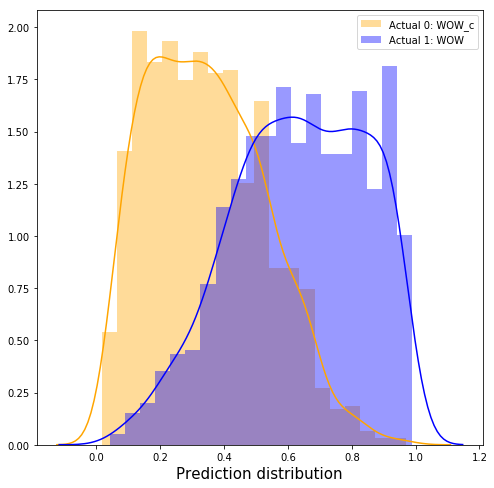

In [78]:
# Visulising the prediction vs the actually y, we can see it's very related
plt.figure(figsize=(8,8))
sns.distplot(graph[graph['y'] == 0]['proba'], color ='orange', bins = 20);
sns.distplot(graph[graph['y'] == 1]['proba'], color ='blue', bins = 20);

plt.legend(['Actual 0: WOW_c','Actual 1: WOW'],loc = 'upper right')
plt.xlabel('Prediction distribution', size = 15);
# plt.xlim((0,1));

In [79]:
#getting the confusion matrix
pd.DataFrame(confusion_matrix(model.predict(Xtvect_te),y_test), 
             columns = ['Predict to be WOW_c', 'Predict to be WOW'], 
             index = ['WOW_c','WOW'])

,Predict to be WOW_c,Predict to be WOW
WOW_c,966,338
WOW,273,922


## 3.3 Sentiment Analysis

In [80]:
from textblob import TextBlob, Word

In [81]:
sentiment_set = df[['X','y']]

In [82]:
wow_c_sentiment = [(TextBlob(i).sentiment[0],TextBlob(i).sentiment[1]) for i in sentiment_set[sentiment_set['y']==0]['X']]
wow_sentiment = [(TextBlob(i).sentiment[0],TextBlob(i).sentiment[1]) for i in sentiment_set[sentiment_set['y']==1]['X']]

In [83]:
wow_c_sentiment = pd.DataFrame(wow_c_sentiment, columns = ['polarity','subjectivity'])
wow_sentiment = pd.DataFrame(wow_sentiment, columns = ['polarity','subjectivity'])

In [91]:
wow_c_sentiment['positive'] = wow_c_sentiment['polarity'].map(lambda x : 1 if x >0 else 0 )
wow_sentiment['positive'] = wow_sentiment['polarity'].map(lambda x : 1 if x >0 else 0 )

In [92]:
wow_c_sentiment['positive'].mean()

0.4774774774774775

In [93]:
wow_sentiment['positive'].mean()

0.47889577915583115

In [41]:
print(f"Polarity for WOW posting {wow_sentiment['polarity'].mean()}")
print(f"Polarity for WOW Classic posting {wow_c_sentiment['polarity'].mean()}")
print(f"Subjectivity for WOW posting {wow_sentiment['subjectivity'].mean()}")
print(f"Subjectivity for WOW Classic posting {wow_c_sentiment['subjectivity'].mean()}")

Polarity for WOW posting 0.08316940421851383
Polarity for WOW Classic posting 0.08013078280058208
Subjectivity for WOW posting 0.3656589806882277
Subjectivity for WOW Classic posting 0.33989935918670333


## 4. Getting new posts to test accuracy of the model

In [24]:
new_wow = get_dataframe('wow')
new_wow_c = get_dataframe('classicwow')

1000


In [27]:
dft = magic(new_wow, new_wow_c) # data cleaning and creating stem features

In [28]:
Xnew = dft['Xs']
ynew = dft['y']

In [29]:
#numnber of new post
len(dft)

1977

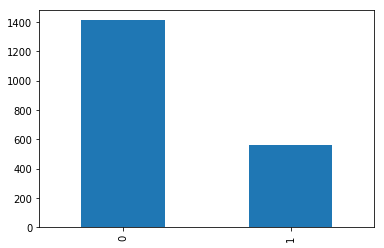

In [45]:
# Number of new post, 0 is wow_c, 1 is wow
p = dft['y'].value_counts().plot.bar();

In [30]:
Xnew_t = pd.DataFrame(tvect.transform(Xnew).toarray() ,columns = tvect.get_feature_names())

In [31]:
outcome = pd.DataFrame(confusion_matrix(model.predict(Xnew_t),ynew), 
             columns = ['Predict to be WOW_c', 'Predict to be WOW'], 
             index = ['WOW_c','WOW'])

In [32]:
outcome # confusion matrix

,Predict to be WOW_c,Predict to be WOW
WOW_c,1144,131
WOW,268,434


In [33]:
model.score(Xnew_t, ynew) #accuracy

0.7981790591805766

In [34]:
mistake = dft[model.predict(Xnew_t) != ynew]

In [35]:
mistake # checking to see the mis classified articles. 

,title,body,created,X,y,Xs
7,Hallow's End Guide! With Spreadsheet,Hello just wanted to share this with yall i s...,1.571438e+09,Hallow's End Guide! With Spreadsheet Hello jus...,1,hallow end guid with spreadsheet hello just wa...
14,"GatherMate2 question. Red=location, Yellow=coo...",,1.571437e+09,"GatherMate2 question. Red=location, Yellow=coo...",1,gathermate2 question red locat yellow coord gr...
23,World of Warcraft Classic - EP1 | Troll Hunter,,1.571432e+09,World of Warcraft Classic - EP1 | Troll Hunter,1,world of warcraft classic ep1 troll hunter
28,Realm of Shadows leak on 4chan,,1.571431e+09,Realm of Shadows leak on 4chan,1,realm of shadow leak on 4chan
31,You Shall Not Pass!,,1.571431e+09,You Shall Not Pass!,1,you shall not pass
...,...,...,...,...,...,...
1948,Are Shamans Really That Bad as dps?,"I wanna play a shaman, they look very fun and ...",1.571196e+09,Are Shamans Really That Bad as dps?I wanna pla...,0,are shaman realli that bad as dp wanna play sh...
1959,WoW icon photography,I had an idea that I thought would be really c...,1.571195e+09,WoW icon photographyI had an idea that I thoug...,0,wow icon photographyi had an idea that thought...
1962,Wouldn't it be cool if..,Blizzard made a server where you only have 1 l...,1.571195e+09,Wouldn't it be cool if..Blizzard made a server...,0,wouldn it be cool if blizzard made server wher...
1966,Activision Blizzard is stance dancing now that...,,1.571194e+09,Activision Blizzard is stance dancing now that...,0,activis blizzard is stanc danc now that think ...
